# Project 4 - WEST NILE VIRUS

## Problem Statement

West Nile virus can cause a fatal neurological disease in humans. It is mainly transmitted to people through the bites of infected mosquitoes. Treatments often involve hospitalization, intravenous fluids, respiratory support, and prevention of secondary infections. 

No vaccine is available for humans. 

Studies estimated the economic impact of the WNV disease outbreak in 2002 in Louisiana, which resulted in 24 deaths. Total epidemic costs were about 20.14 million for the 329 cases, including 9.2 million for mosquito control and public health agency costs. As mosquito control is an expensive exercise, the state would like our team to propose a cost-effective plan for pesticide deployment.

## Executive Summary

If you want to, it's great to use relative links to direct your audience to various sections of a notebook. **HERE'S A DEMONSTRATION WITH THE CURRENT SECTION HEADERS**:

### Contents: (TOBE UPDATED)
- [2017 Data Import & Cleaning](#Data-Import-and-Cleaning)
- [2018 Data Import and Cleaning](#2018-Data-Import-and-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Visualization](#Visualize-the-data)
- [Descriptive and Inferential Statistics](#Descriptive-and-Inferential-Statistics)
- [Outside Research](#Outside-Research)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

**If you combine your problem statement, executive summary, data dictionary, and conclusions/recommendations, you have an amazing README.md file that quickly aligns your audience to the contents of your project.** Don't forget to cite your data sources!

*All libraries used should be added here*

In [55]:
# import libraries
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.image import imread

sns.set(font_scale=1.5)
%matplotlib inline

## Data Import and Cleaning

In [259]:
# import data
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
weather = pd.read_csv('../data/weather.csv')
spray = pd.read_csv('../data/spray.csv')

### TRAIN & TEST DATA

In [3]:
# delete variables that are not useful
# address related are deleted as location is determined by Latitude and Longuitude
# checked online all species are relevant for WNV
def del_var(data):
    try:
        del data['Address']
        del data['Block']
        del data['Street']
        del data['AddressNumberAndStreet']
        del data['AddressAccuracy']
        del data['Species']
    except:
        pass

In [4]:
del_var(train)

In [5]:
del_var(test)

In [6]:
# combine test results for traps with multiple rows in any single day, since we are ignoring species
import datetime
def aggregate_train(data):
    grouped = data.groupby(['Date', 'Trap', 'Latitude', 'Longitude'])
    aggregated = pd.DataFrame(grouped.agg({'NumMosquitos': np.sum, 'WnvPresent': np.max})).reset_index()
    aggregated.sort_values(by='NumMosquitos', ascending = False)
    aggregated.sort_values(by='Date', inplace=True)
    aggregated = aggregated.reset_index(drop = True)
    aggregated['Date'] = pd.to_datetime(aggregated.Date, format='%Y-%m-%d')
    aggregated['Year'] = pd.DatetimeIndex(aggregated['Date']).year 
    aggregated['Month'] = pd.DatetimeIndex(aggregated['Date']).month
    return aggregated

def aggregate_test(data):
    data['Date'] = pd.to_datetime(data.Date, format='%Y-%m-%d')
    data['Year'] = pd.DatetimeIndex(data['Date']).year 
    data['Month'] = pd.DatetimeIndex(data['Date']).month
    return data

In [7]:
agg_train = aggregate_train(train)

In [8]:
agg_test = aggregate_test(test)

In [9]:
# there are no missing data in agg_train
agg_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4616 entries, 0 to 4615
Data columns (total 8 columns):
Date            4616 non-null datetime64[ns]
Trap            4616 non-null object
Latitude        4616 non-null float64
Longitude       4616 non-null float64
NumMosquitos    4616 non-null int64
WnvPresent      4616 non-null int64
Year            4616 non-null int64
Month           4616 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 288.6+ KB


In [10]:
# there are no missing data in agg_test
agg_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 7 columns):
Id           116293 non-null int64
Date         116293 non-null datetime64[ns]
Trap         116293 non-null object
Latitude     116293 non-null float64
Longitude    116293 non-null float64
Year         116293 non-null int64
Month        116293 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 6.2+ MB


In [11]:
import math
# source: https://www.johndcook.com/blog/python_longitude_latitude/
def distance_on_unit_sphere(lat1, long1, lat2, long2):

    # Convert latitude and longitude to spherical coordinates in radians
    degrees_to_radians = math.pi/180.0

    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians

    # theta = longitude
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians

    # Compute spherical distance from spherical coordinates.

    # For two locations in spherical coordinates
    # (1, theta, phi) and (1, theta', phi')
    # cosine( arc length ) =
    # sin phi sin phi' cos(theta-theta') + cos phi cos phi'
    # distance = rho * arc length

    cos = (math.sin(phi1)*math.sin(phi2)*math.cos(theta1 - theta2) +
    math.cos(phi1)*math.cos(phi2))
    arc = math.acos( cos )

    # Remember to multiply arc by the radius of the earth
    # in your favorite set of units to get length.
    return arc

In [12]:
# weather stations 1 and 2 lat/longitude
# Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
# Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level
station_1_lat = 41.995
station_1_lon = -87.933
station_2_lat = 41.786
station_2_lon = -87.752
# function to calculate whether station 1 or 2 (from weather.csv) is closer
def closest_station(lat, lon):
    if (distance_on_unit_sphere(lat, lon, station_1_lat, station_1_lon) <
        distance_on_unit_sphere(lat, lon, station_2_lat, station_2_lon)):
        return 1
    else: return 2

In [13]:
## REVISED 3/8/2019
# add station to indicate whether station 1 or 2 is closer
# create unique variable to combine train, weather and spray data
def station_var (data):
    data['Station'] = [closest_station(a,b) for (a, b) in zip(data.Latitude, data.Longitude)]
    data['unique'] =  data['Station'].astype(str) + str(": ") + data['Date'].astype(str)

In [16]:
station_var(agg_train)
station_var(agg_test)

###  WEATHER DATA

In [244]:
# Many numerical columns are imported as objects
weather.dtypes

Station          int64
Date            object
Tmax             int64
Tmin             int64
Tavg            object
Depart           int64
DewPoint         int64
WetBulb         object
Heat             int64
Cool             int64
Sunrise         object
Sunset          object
CodeSum         object
Depth           object
Water1          object
SnowFall        object
PrecipTotal    float64
StnPressure     object
SeaLevel        object
ResultSpeed    float64
ResultDir        int64
AvgSpeed       float64
Daytime          int64
unique          object
dtype: object

In [245]:
# Convert Date to date format
weather['Date'] = pd.to_datetime(weather['Date'], format='%Y-%m-%d')

In [246]:
# Calculate missing Tavg as average of Tmax and Tmin
weather['Tavg'] = weather.apply([lambda row: (row.Tmax + row.Tmin) / 2 if row.Tavg == 'M' else row.Tavg], axis=1)
weather['Tavg'] = pd.to_numeric(weather['Tavg'])

In [247]:
# Fill missing WetBulb from the other station
for k, v in enumerate(weather['WetBulb']):
    if v == 'M' and weather.iloc[k]['Station'] == 1:
        weather.loc[k,'WetBulb'] = weather['WetBulb'][k+1]
    if v == 'M' and weather.iloc[k]['Station'] == 2:
        weather.loc[k,'WetBulb'] = weather['WetBulb'][k-1]
weather['WetBulb'] = pd.to_numeric(weather['WetBulb'])

In [248]:
# Engineer feature for daytime in minutes
sunset = pd.to_timedelta([i[:2] + ':' + i[2:] + ':00' for i in weather[weather['Station']==1]['Sunset']])
sunrise = pd.to_timedelta([i[:2] + ':' + i[2:] + ':00' for i in weather[weather['Station']==1]['Sunrise']])
daytime = sunset - sunrise
daytime_m = list([int(str(i).split(":")[0][-2:]) * 60 + int(str(i).split(":")[1]) for i in daytime])
weather['Daytime'] = list(sum((zip(daytime_m,daytime_m)),()))

In [249]:
# Fill trace values as 0.005
weather['PrecipTotal'].replace('  T', '0.005', inplace=True)
# Fill missing values from the other Station
for k, v in enumerate(weather['PrecipTotal']):
    if v == 'M' and weather.iloc[k]['Station'] == 1:
        weather.loc[k,'PrecipTotal'] = weather['PrecipTotal'][k+1]
    if v == 'M' and weather.iloc[k]['Station'] == 2:
        weather.loc[k,'PrecipTotal'] = weather['PrecipTotal'][k-1]
weather['PrecipTotal'] = pd.to_numeric(weather['PrecipTotal'])

In [250]:
# Fill missing values for Depart, Heat, Cool, AvgSpeed from the other station
cols = ['Depart', 'Heat', 'Cool', 'AvgSpeed']
for col in cols:
    for k, v in enumerate(weather[col]):
        if v == 'M' and weather.iloc[k]['Station'] == 1:
            weather.loc[k,col] = weather[col][k+1]
        if v == 'M' and weather.iloc[k]['Station'] == 2:
            weather.loc[k,col] = weather[col][k-1]
    weather[col] = pd.to_numeric(weather[col])

In [251]:
# Check column data types after cleaning
# We skipped cleaning for CodeSum, Depth, Water1, SnowFall, StnPressure, SeaLevel
# because we do not find them useful
weather.dtypes

Station                 int64
Date           datetime64[ns]
Tmax                    int64
Tmin                    int64
Tavg                  float64
Depart                  int64
DewPoint                int64
WetBulb                 int64
Heat                    int64
Cool                    int64
Sunrise                object
Sunset                 object
CodeSum                object
Depth                  object
Water1                 object
SnowFall               object
PrecipTotal           float64
StnPressure            object
SeaLevel               object
ResultSpeed           float64
ResultDir               int64
AvgSpeed              float64
Daytime                 int64
unique                 object
dtype: object

## Combine weather & train/test data for ease of analysis

In [252]:
# create unique variable to combine train and weather data
weather['unique'] = weather['Station'].astype(str) + str(": ") + weather['Date'].astype(str)

In [253]:
combined_train = pd.merge(agg_train, weather, how="inner", on="unique")
combined_test = pd.merge(agg_test, weather, how="inner", on="unique")

In [254]:
# dropping duplicate and unnecessary variables
combined_train = combined_train.drop(["Date_y", "Station_y", "unique"], axis=1)
combined_train.rename(columns={"Date_x": "Date"}, inplace=True)
combined_train.rename(columns={"Station_x": "Station"}, inplace=True)
combined_test = combined_test.drop(["Date_y", "Station_y", "unique"], axis=1)
combined_test.rename(columns={"Station_x": "Station"}, inplace=True)

# NEW 3/8/2019 - to create YYMM
# bin the surveillance efforts by month
combined_train ["YYMM"] = tuple(zip(combined_train.Year, combined_train.Month))
combined_test ["YYMM"] = tuple(zip(combined_test.Year, combined_test.Month))

In [255]:
combined_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4616 entries, 0 to 4615
Data columns (total 31 columns):
Date            4616 non-null datetime64[ns]
Trap            4616 non-null object
Latitude        4616 non-null float64
Longitude       4616 non-null float64
NumMosquitos    4616 non-null int64
WnvPresent      4616 non-null int64
Year            4616 non-null int64
Month           4616 non-null int64
Station         4616 non-null int64
Tmax            4616 non-null int64
Tmin            4616 non-null int64
Tavg            4616 non-null float64
Depart          4616 non-null int64
DewPoint        4616 non-null int64
WetBulb         4616 non-null int64
Heat            4616 non-null int64
Cool            4616 non-null int64
Sunrise         4616 non-null object
Sunset          4616 non-null object
CodeSum         4616 non-null object
Depth           4616 non-null object
Water1          4616 non-null object
SnowFall        4616 non-null object
PrecipTotal     4616 non-null float64
StnPr

In [256]:
# how many trap observations per month
combined_train["YYMM"].value_counts().sort_index()

(2007, 5)      18
(2007, 6)     120
(2007, 7)     260
(2007, 8)     574
(2007, 9)     382
(2007, 10)    105
(2009, 5)      41
(2009, 6)     255
(2009, 7)     285
(2009, 8)     180
(2009, 9)     208
(2009, 10)     37
(2011, 6)     193
(2011, 7)     263
(2011, 8)     252
(2011, 9)     280
(2013, 6)     248
(2013, 7)     285
(2013, 8)     357
(2013, 9)     273
Name: YYMM, dtype: int64

## Data Cleaning - Spray Data

In [260]:
#NEW 3/8/2019 - to create YYMM
spray['Date'] = pd.to_datetime(spray.Date, format='%Y-%m-%d')
spray['Year'] = pd.DatetimeIndex(spray['Date']).year 
spray['Month'] = pd.DatetimeIndex(spray['Date']).month
spray["YYMM"] = tuple(zip(spray.Year, spray.Month))
del spray['Time']

In [258]:
# there are no missing data in spray
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 7 columns):
Date         14835 non-null datetime64[ns]
Latitude     14835 non-null float64
Longitude    14835 non-null float64
Year         14835 non-null int64
Month        14835 non-null int64
YYMM         14835 non-null object
spray        14835 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 811.4+ KB


## EDA

#### Maps of WNV by year

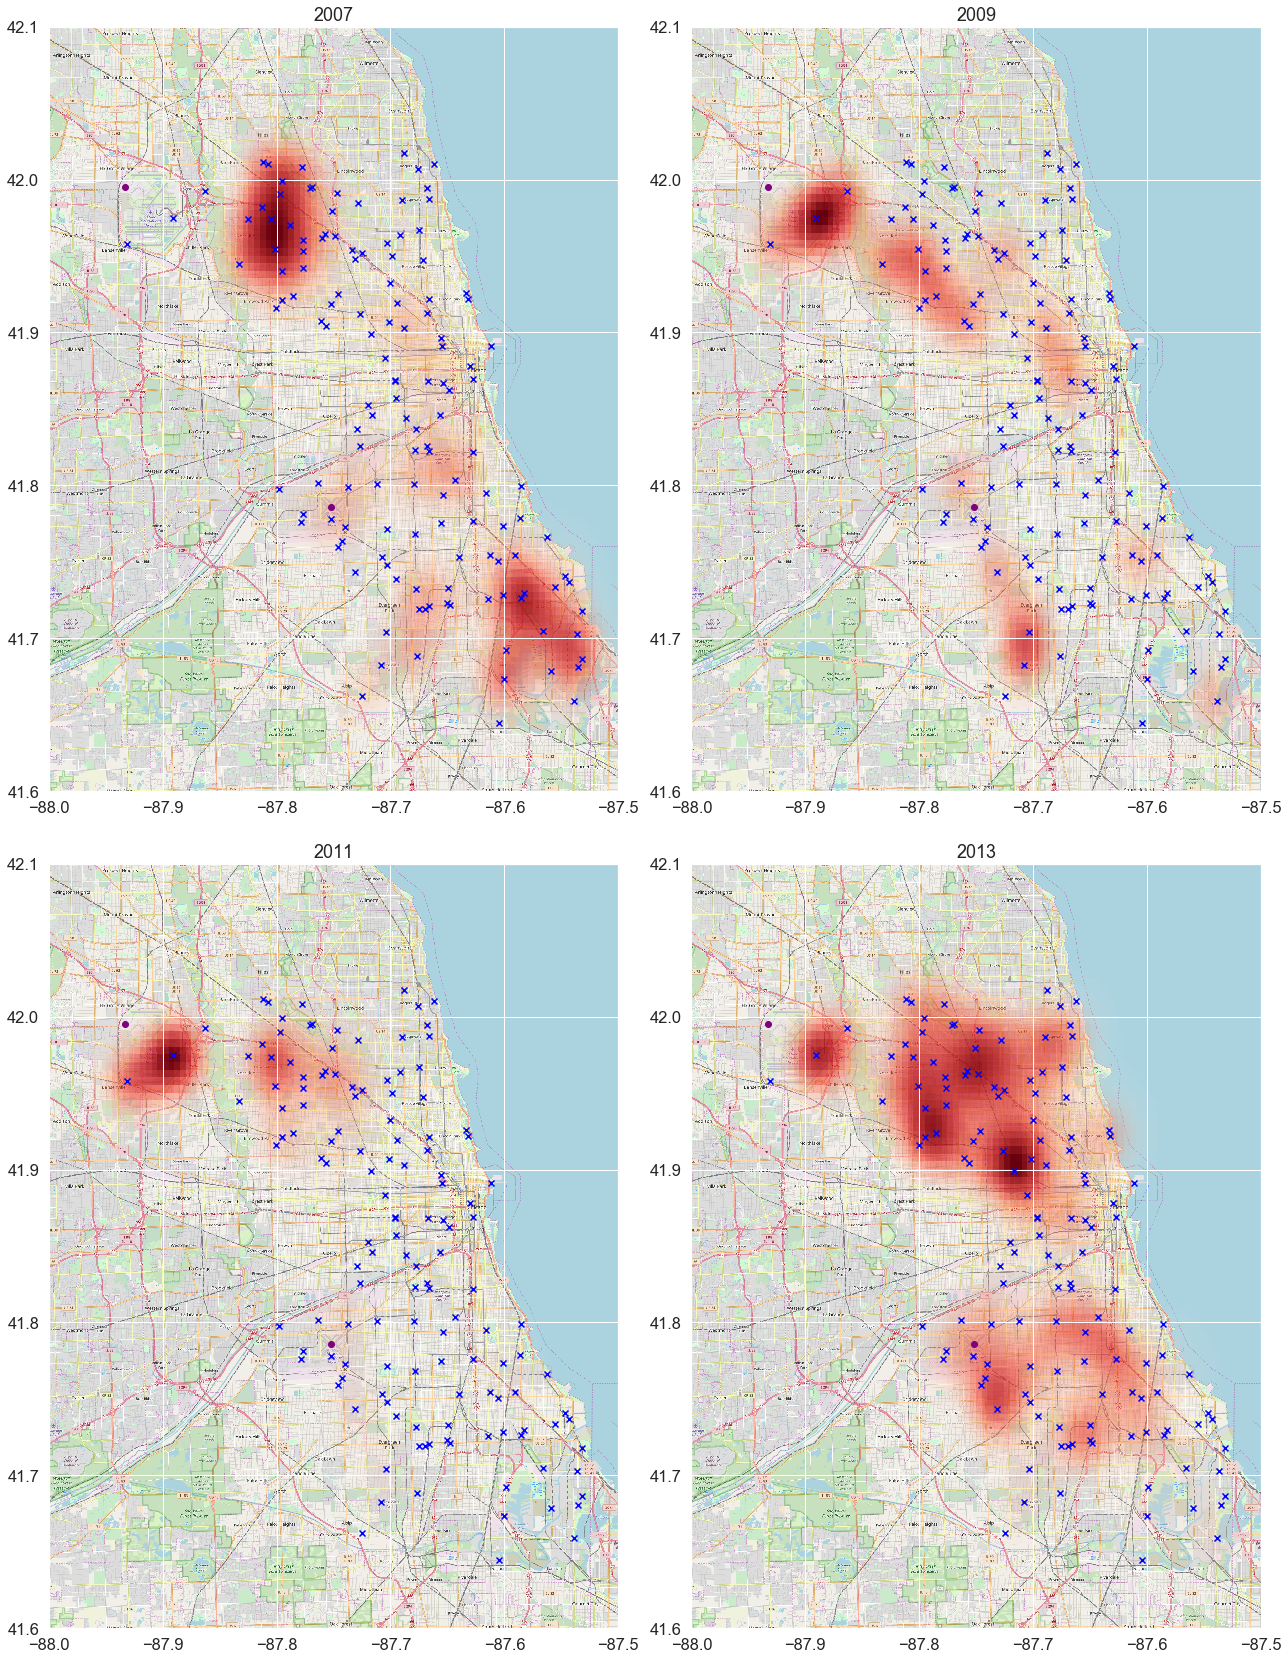

In [139]:
# source: https://www.kaggle.com/neilsummers/west-nile-heatmap-by-year
from sklearn.neighbors import KernelDensity

mapdata = imread('../data/map1.png')
traps = pd.read_csv('../data/train.csv', parse_dates=['Date'])[['Date', 'Trap', 'Longitude', 'Latitude', 'WnvPresent']]

alpha_cm = plt.cm.Reds
alpha_cm._init()
alpha_cm._lut[:-3,-1] = np.linspace(0, 1, alpha_cm.N)
aspect = mapdata.shape[0] / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(18,24))
for year, subplot in zip([2007, 2009, 2011, 2013], [221, 222, 223, 224]):
    sightings = traps[(traps['WnvPresent'] > 0) & (traps['Date'].apply(lambda x: x.year) == year)]
    sightings = sightings.groupby(['Date', 'Trap', 'Longitude', 'Latitude']).max()['WnvPresent'].reset_index()
    X = sightings[['Longitude', 'Latitude']].values
    kd = KernelDensity(bandwidth=0.02)
    kd.fit(X)

    xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
    gridpoints = np.array([xv.ravel(),yv.ravel()]).T
    zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))
    plt.subplot(subplot)
    plt.gca().set_title(year)
    plt.imshow(mapdata,
               extent=lon_lat_box,
               aspect=aspect)
    plt.imshow(zv, 
               origin='lower',
               cmap=alpha_cm,
               extent=lon_lat_box,
               aspect=aspect)
    plt.tight_layout()
    locations = traps[['Longitude', 'Latitude']].drop_duplicates().values
    plt.scatter(locations[:,0], locations[:,1], c='blue', marker='x')
    plt.scatter([station_1_lon, station_2_lon], [station_1_lat,station_2_lat], c='purple', marker='o')

#### Maps of Spray activities by year

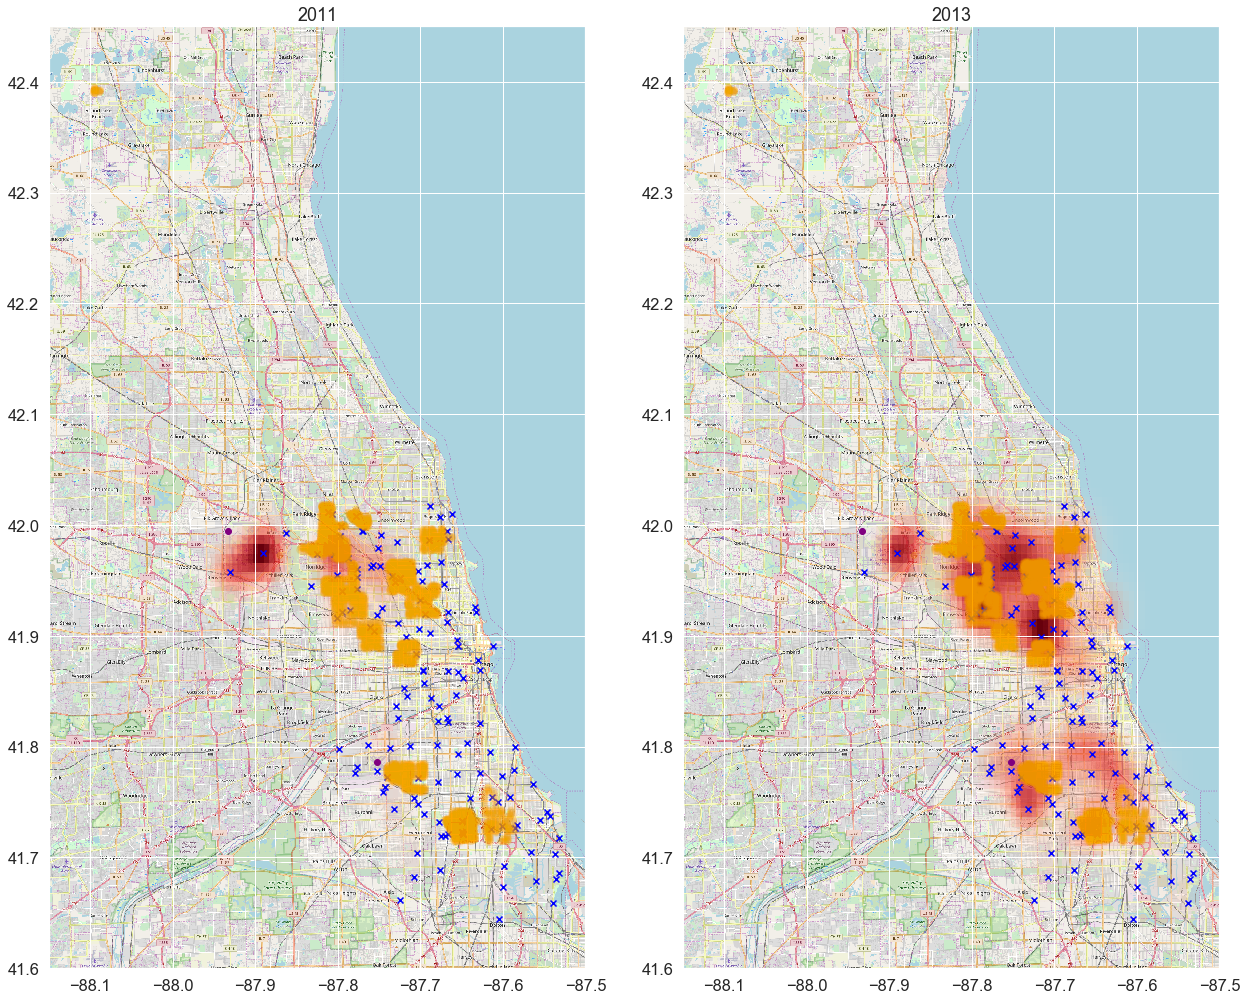

In [87]:
mapdata = imread('../data/map2.png')

lon_lat_box = (-88.15, -87.5, 41.6, 42.45)

plt.figure(figsize=(18,14))
for year, subplot in zip([2011, 2013], [121, 122]):
    sightings = traps[(traps['WnvPresent'] > 0) & (traps['Date'].apply(lambda x: x.year) == year)]
    sightings = sightings.groupby(['Date', 'Trap','Longitude', 'Latitude']).max()['WnvPresent'].reset_index()
    X = sightings[['Longitude', 'Latitude']].values
    kd = KernelDensity(bandwidth=0.02)
    kd.fit(X)

    xv,yv = np.meshgrid(np.linspace(-88.15, -87.5, 100), np.linspace(41.6, 42.45, 100))
    gridpoints = np.array([xv.ravel(),yv.ravel()]).T
    zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))
    plt.subplot(subplot)
    plt.gca().set_title(year)
    plt.imshow(mapdata,
               extent=lon_lat_box,
               aspect=aspect)
    plt.imshow(zv, 
               origin='lower',
               cmap=alpha_cm,
               extent=lon_lat_box,
               aspect=aspect)
    plt.tight_layout()
    locations_trap = traps[['Longitude', 'Latitude']].drop_duplicates().values
    plt.scatter(locations_trap[:,0], locations_trap[:,1], c='blue', marker='x')
    plt.scatter([station_1_lon, station_2_lon], [station_1_lat,station_2_lat], c='purple', marker='o')
    locations_spray = spray[['Longitude', 'Latitude']].drop_duplicates().values
    plt.scatter(locations_spray[:,0], locations_spray[:,1], c='orange', alpha=0.05)

#### Pairplot for weather data

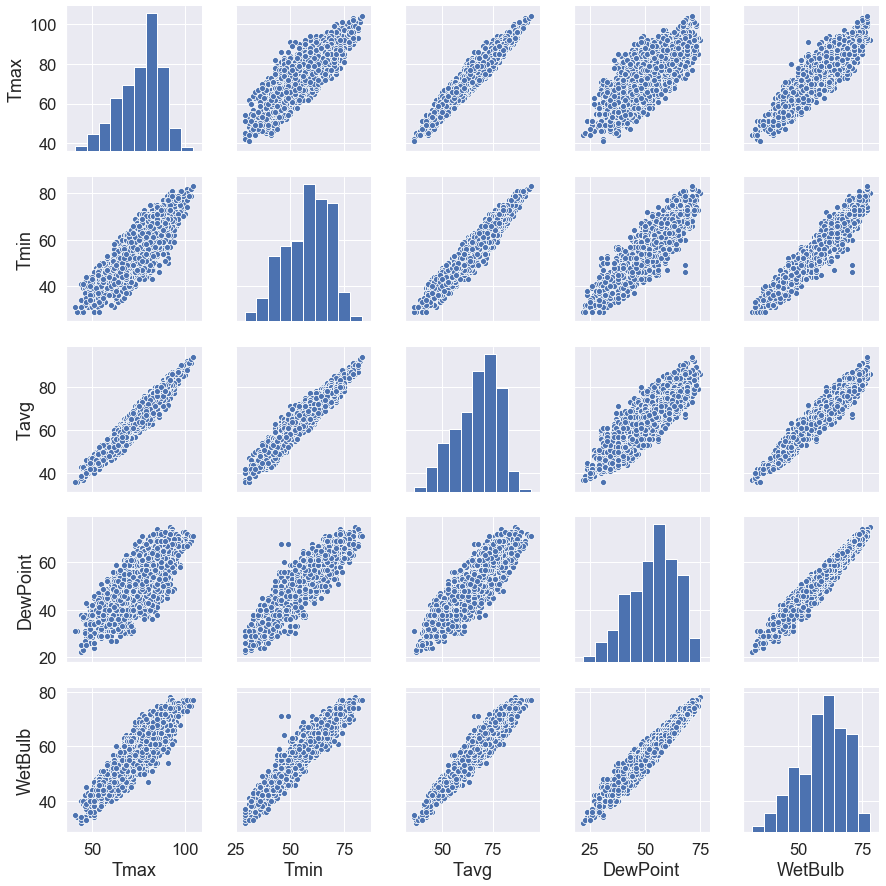

In [88]:
# look at relationships between features describing temperature
sns.pairplot(weather[['Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb']])

#### Visualizing the trap locations in comparison with the two weather stations

In [ ]:
# not necessary anymore
"""
# look at dispersion of traps geographically
plt.scatter(agg_train.Longitude, agg_train.Latitude, c = agg_train.Station)
plt.scatter([station_1_lon, station_2_lon], [station_1_lat,station_2_lat], c = 'r')
plt.show()
"""

#### Top 20 locations of highest number of mosquitoes

In [140]:
## revised 5/8/2019
#top 20 locations of highest number of mosquitoes
lat_long = combined_train.groupby(["Latitude","Longitude"])['NumMosquitos'].agg(['mean','count'])
lat_long= lat_long.sort_values(by="mean", ascending=False).head(20)
#total_mosquitoes = total_mosquitoes.reset_index()
#sum = total no. of mosquitoes in the location
#count = no. of counts (by unique days)

lat_long

mean  count
Latitude  Longitude                    
41.673408 -87.599862  328.303030     66
41.974689 -87.890615  284.925926     54
41.702724 -87.536497  249.000000     12
41.726465 -87.585413  157.714286     63
41.688324 -87.676709   69.052632     19
41.686398 -87.531635   65.538462     13
41.704572 -87.565666   58.157895     57
41.954690 -87.800991   55.373134     67
41.743402 -87.731435   49.121951     41
41.957799 -87.930995   48.479167     48
41.662014 -87.724608   47.303030     66
41.680946 -87.535198   44.741379     58
42.008314 -87.777921   44.466667     60
41.682587 -87.707973   42.916667     60
41.798697 -87.736812   36.627119     59
41.992478 -87.862995   36.024390     41
41.981964 -87.812827   35.615385     13
41.731922 -87.677512   34.000000     17
41.659112 -87.538693   33.980000     50
41.678618 -87.559308   32.571429     42

In [141]:
## revised 5/8/2019
#period with highest number of mosquitoes 
total_mosquitoes = combined_train.groupby(["YYMM"])['NumMosquitos'].agg(['mean','count'])
total_mosquitoes= total_mosquitoes.sort_values(by="mean", ascending=False).head(20)
#total_mosquitoes = total_mosquitoes.reset_index()

total_mosquitoes

mean  count
YYMM                        
(2007, 8)   69.712544    574
(2013, 7)   44.810526    285
(2013, 8)   35.593838    357
(2011, 7)   32.110266    263
(2009, 7)   30.992982    285
(2009, 6)   28.980392    255
(2007, 7)   27.688462    260
(2007, 9)   24.345550    382
(2013, 9)   22.912088    273
(2011, 6)   20.979275    193
(2013, 6)   18.995968    248
(2007, 10)  16.247619    105
(2009, 8)   13.033333    180
(2011, 9)   11.917857    280
(2011, 8)   11.777778    252
(2009, 9)   10.274038    208
(2009, 10)   5.729730     37
(2009, 5)    4.634146     41
(2007, 6)    3.566667    120
(2007, 5)    2.222222     18

In [142]:
## revised 5/8/2019
#period with highest number of WNV presents
total_WNV = combined_train.groupby(["YYMM"])['WnvPresent'].agg(['mean','count'])
total_WNV= total_WNV.sort_values(by="mean", ascending=False).head(20)

total_WNV

mean  count
YYMM                       
(2013, 8)   0.266106    357
(2007, 8)   0.222997    574
(2013, 9)   0.194139    273
(2011, 9)   0.075000    280
(2013, 7)   0.070175    285
(2011, 8)   0.063492    252
(2007, 9)   0.060209    382
(2009, 8)   0.044444    180
(2011, 7)   0.026616    263
(2009, 9)   0.024038    208
(2007, 10)  0.019048    105
(2009, 7)   0.014035    285
(2007, 7)   0.007692    260
(2013, 6)   0.004032    248
(2007, 6)   0.000000    120
(2009, 10)  0.000000     37
(2011, 6)   0.000000    193
(2009, 6)   0.000000    255
(2009, 5)   0.000000     41
(2007, 5)   0.000000     18

In [143]:
## revised 5/8/2019
#traps corresponding to the locations of highest number of mosquitoes 
total_mosquitoes = combined_train.groupby(["Trap"])['NumMosquitos'].agg(['mean','count'])
total_mosquitoes= total_mosquitoes.sort_values(by="mean", ascending=False).head(20)
#total_mosquitoes = total_mosquitoes.reset_index()

total_mosquitoes

mean  count
Trap                   
T115  328.303030     66
T900  284.925926     54
T103  249.000000     12
T138  157.714286     63
T086   69.052632     19
T215   65.538462     13
T128   58.157895     57
T002   55.373134     67
T225   49.121951     41
T903   48.479167     48
T135   47.303030     66
T212   44.741379     58
T008   44.466667     60
T158   42.916667     60
T114   36.627119     59
T009   35.925926     54
T096   34.000000     17
T221   33.980000     50
T200   32.571429     42
T223   32.025000     40

#### No. of Mosquitoes by Temp

In [144]:
combined_train_ = combined_train[combined_train["WnvPresent"]== 1]
combined_train_

Date  Trap   Latitude  Longitude  NumMosquitos  WnvPresent  Year  \
305  2007-07-18  T215  41.686398 -87.531635            85           1  2007   
346  2007-07-25  T115  41.673408 -87.599862          3002           1  2007   
398  2007-08-01  T096  41.731922 -87.677512            41           1  2007   
403  2007-08-01  T103  41.702724 -87.536497           510           1  2007   
406  2007-08-01  T081  41.821582 -87.627796            24           1  2007   
...         ...   ...        ...        ...           ...         ...   ...   
4551 2013-09-19  T013  41.923738 -87.785288            30           1  2013   
4556 2013-09-26  T155  41.776156 -87.778927             4           1  2013   
4583 2013-09-26  T035  41.763733 -87.742302             6           1  2013   
4607 2013-09-26  T003  41.964242 -87.757639            13           1  2013   
4615 2013-09-26  T900  41.974689 -87.890615            80           1  2013   

      Month  Station  Tmax  ...  Water1  SnowFall  PrecipTotal  StnPressure  \
305       7        2    85  ...       M         M         0.92        29.18   
346       7        2    83  ...       M         M         0.00        29.35   
398       8        2    91  ...       M         M         0.00        29.34   
403       8        2    91  ...       M         M         0.00        29.34   
406       8        2    91  ...       M         M         0.00        29.34   
...     ...      ...   ...  ...     ...       ...          ...          ...   
4551      9        1    84  ...       M       0.0         0.84        29.14   
4556      9        2    75  ...       M         M         0.00        29.40   
4583      9        2    75  ...       M         M         0.00        29.40   
4607      9        1    75  ...       M       0.0         0.00        29.34   
4615      9        1    75  ...       M       0.0         0.00        29.34   

      SeaLevel  ResultSpeed  ResultDir AvgSpeed  Daytime       YYMM  
305      29.83         10.3         24     10.6 14:52:00  (2007, 7)  
346      29.99          6.4         23      7.0 14:40:00  (2007, 7)  
398      29.98          2.1         13      3.7 14:26:00  (2007, 8)  
403      29.98          2.1         13      3.7 14:26:00  (2007, 8)  
406      29.98          2.1         13      3.7 14:26:00  (2007, 8)  
...        ...          ...        ...      ...      ...        ...  
4551     29.87          8.3         16     10.6 12:19:00  (2013, 9)  
4556     30.04          4.1          9      4.6 11:59:00  (2013, 9)  
4583     30.04          4.1          9      4.6 11:59:00  (2013, 9)  
4607     30.04          3.8          8      4.2 11:59:00  (2013, 9)  
4615     30.04          3.8          8      4.2 11:59:00  (2013, 9)  

[385 rows x 31 columns]

In [145]:
temp = combined_train_.groupby(["Tavg","WetBulb","Year"])['NumMosquitos'].agg(['sum']).reset_index()
temp = pd.DataFrame(temp)
temp.sort_values("Tavg")
temp.to_csv(r'../data/temp.csv')

Text(0, 0.5, 'No. of mosquitoes')

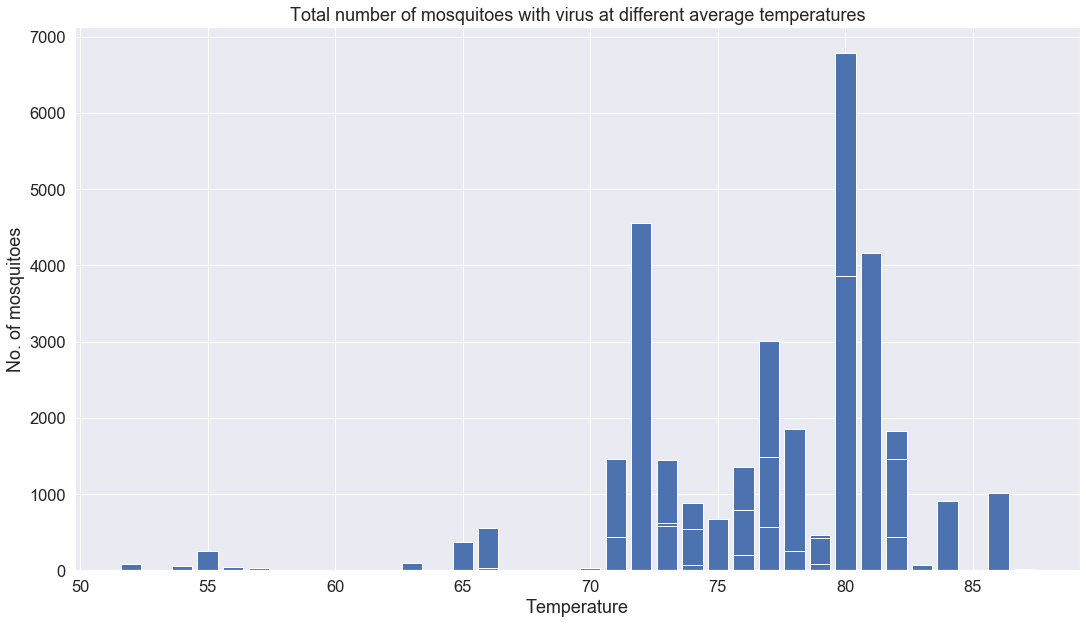

In [146]:
plt.figure(figsize=(18,10))
plt.bar(temp['Tavg'],temp['sum'])
plt.title("Total number of mosquitoes with virus at different average temperatures")
plt.xlabel("Temperature")
plt.ylabel("No. of mosquitoes")

#### Traps corresponding to the locations of highest number of mosquitoes 

In [147]:
#traps corresponding to the locations of highest number of mosquitoes 
total_mosquitoes = combined_train_.groupby(["Trap"])['NumMosquitos'].agg(['sum','count'])
total_mosquitoes= total_mosquitoes.sort_values(by="sum", ascending=False).head(20).reset_index()
#total_mosquitoes = total_mosquitoes.reset_index()

total_mosquitoes

Trap    sum  count
0   T115  15373     11
1   T138   7784      8
2   T900   5902     20
3   T128   2215      6
4   T103   1632      4
5   T002   1029     12
6   T030    976      7
7   T086    872      5
8   T225    839     10
9   T008    760      8
10  T135    675      5
11  T221    632      6
12  T212    615      3
13  T158    533      5
14  T009    515      6
15  T003    472     13
16  T233    457      4
17  T082    451      7
18  T903    442      6
19  T013    442      9

Text(0, 0.5, 'No. of mosquitoes')

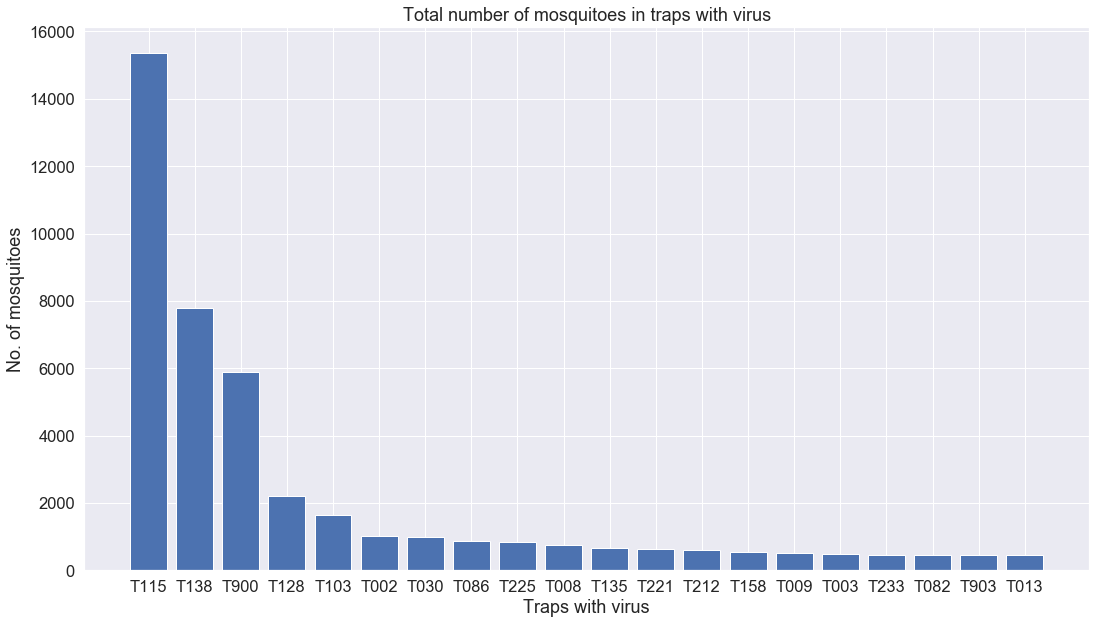

In [148]:
plt.figure(figsize=(18,10))
plt.bar(total_mosquitoes["Trap"],total_mosquitoes["sum"])
plt.title("Total number of mosquitoes in traps with virus")
plt.xlabel("Traps with virus")
plt.ylabel("No. of mosquitoes")

#### Grouping data into years as spray data contains only 2011 and 2013 data.

In [149]:
list_var={}
def grouping_by_year(data):
    grps = data.groupby("Year")
    grps_key = list(grps.groups.keys())
    for i in range(len(list(grps.groups.keys()))):
        list_var["grouped_data_{}".format(grps_key[i])] = grps.get_group(grps_key[i])
    return list_var, grps_key

In [150]:
grouping_by_year(combined_train)

({'grouped_data_2007':            Date  Trap   Latitude  Longitude  NumMosquitos  WnvPresent  Year  \
  0    2007-05-29  T002  41.954690 -87.800991             2           0  2007   
  1    2007-05-29  T148  42.017430 -87.687769             1           0  2007   
  2    2007-05-29  T143  41.999129 -87.795585             1           0  2007   
  3    2007-05-29  T015  41.974089 -87.824812             5           0  2007   
  4    2007-05-29  T007  41.994991 -87.769279             1           0  2007   
  ...         ...   ...        ...        ...           ...         ...   ...   
  1454 2007-10-09  T128  41.704572 -87.565666             4           0  2007   
  1455 2007-10-09  T115  41.673408 -87.599862           159           0  2007   
  1456 2007-10-09  T107  41.729669 -87.582699             4           0  2007   
  1457 2007-10-09  T200  41.678618 -87.559308            25           0  2007   
  1458 2007-10-09  T027  41.984809 -87.728492             1           0  2007   
  
    

In [151]:
grouped_data_2007 = list_var["grouped_data_2007"]
grouped_data_2009 = list_var["grouped_data_2009"]
grouped_data_2011 = list_var["grouped_data_2011"]
grouped_data_2013 = list_var["grouped_data_2013"]

In [152]:
list_var2={}
def grouping_by_year_spray(data):
    grps = data.groupby("Year")
    grps_key = list(grps.groups.keys())
    for i in range(len(list(grps.groups.keys()))):
        list_var2["grouped_data_spray{}".format(grps_key[i])] = grps.get_group(grps_key[i])
    return list_var2, grps_key

In [153]:
grouping_by_year_spray(spray)

({'grouped_data_spray2011':            Date   Latitude  Longitude  Year  Month       YYMM
  0    2011-08-29  42.391623 -88.089163  2011      8  (2011, 8)
  1    2011-08-29  42.391348 -88.089163  2011      8  (2011, 8)
  2    2011-08-29  42.391022 -88.089157  2011      8  (2011, 8)
  3    2011-08-29  42.390637 -88.089158  2011      8  (2011, 8)
  4    2011-08-29  42.390410 -88.088858  2011      8  (2011, 8)
  ...         ...        ...        ...   ...    ...        ...
  2204 2011-09-07  41.990155 -87.817828  2011      9  (2011, 9)
  2205 2011-09-07  41.989638 -87.817857  2011      9  (2011, 9)
  2206 2011-09-07  41.989088 -87.817867  2011      9  (2011, 9)
  2207 2011-09-07  41.988812 -87.817618  2011      9  (2011, 9)
  2208 2011-09-07  41.988837 -87.817002  2011      9  (2011, 9)
  
  [2209 rows x 6 columns],
  'grouped_data_spray2013':             Date   Latitude  Longitude  Year  Month       YYMM
  2209  2013-07-17  41.997728 -87.767532  2013      7  (2013, 7)
  2210  2013-07-17  

In [154]:
grouped_data_spray_2011 = list_var2["grouped_data_spray2011"]
grouped_data_spray_2013 = list_var2["grouped_data_spray2013"]

#### Visualizing the trap locations with mosquitoes in comparison with the spray locations

In [155]:
"""
# 2011
plt.scatter(grouped_data_spray_2011.Longitude, grouped_data_spray_2011.Latitude, c = 'r')
plt.scatter(grouped_data_2011.Longitude, grouped_data_2011.Latitude, c = grouped_data_2011.NumMosquitos)
plt.show()
"""

"\n# 2011\nplt.scatter(grouped_data_spray_2011.Longitude, grouped_data_spray_2011.Latitude, c = 'r')\nplt.scatter(grouped_data_2011.Longitude, grouped_data_2011.Latitude, c = grouped_data_2011.NumMosquitos)\nplt.show()\n"

In [156]:
"""
# 2013
plt.scatter(grouped_data_spray_2013.Longitude, grouped_data_spray_2013.Latitude, c = 'r')
plt.scatter(grouped_data_2013.Longitude, grouped_data_2013.Latitude, c = grouped_data_2013.NumMosquitos)
plt.show()
"""

"\n# 2013\nplt.scatter(grouped_data_spray_2013.Longitude, grouped_data_spray_2013.Latitude, c = 'r')\nplt.scatter(grouped_data_2013.Longitude, grouped_data_2013.Latitude, c = grouped_data_2013.NumMosquitos)\nplt.show()\n"

In [158]:
Nummos_bydate = combined_train.groupby(["Date"])['NumMosquitos'].agg(['sum']).reset_index()
Nummos_bydate = pd.DataFrame(Nummos_bydate )
Nummos_bydate .sort_values("Date")

Date   sum
0  2007-05-29    40
1  2007-06-05   127
2  2007-06-26   216
3  2007-06-29    85
4  2007-07-02   240
..        ...   ...
90 2013-08-29  2645
91 2013-09-06  2510
92 2013-09-12  2210
93 2013-09-19  1030
94 2013-09-26   505

[95 rows x 2 columns]

In [159]:
spray["spray"] = 1
Spray_bydate = spray.groupby(["Date"])["spray"].agg(['sum']).reset_index()
Spray_bydate = pd.DataFrame(Spray_bydate )
Spray_bydate .sort_values("Date")

Date   sum
0 2011-08-29    95
1 2011-09-07  2114
2 2013-07-17  2202
3 2013-07-25  1607
4 2013-08-08  1195
5 2013-08-15  2668
6 2013-08-16   141
7 2013-08-22  1587
8 2013-08-29  2302
9 2013-09-05   924

In [164]:
combined_spray_train = pd.merge(Spray_bydate, Nummos_bydate, how="outer", left_on="Date", right_on="Date")

In [165]:
#clean the data frame for combined spray/train data
combined_spray_train.Date.fillna(combined_spray_train.Date, inplace=True)
del combined_spray_train['Date']
combined_spray_train.rename(columns={"sum_x": "Num_spray", "sum_y": "NumMosquitos"}, inplace=True)

In [166]:
combined_spray_train

Num_spray  NumMosquitos
0        95.0           NaN
1      2114.0           NaN
2      2202.0           NaN
3      1607.0        1974.0
4      1195.0        3188.0
..        ...           ...
95        NaN        2865.0
96        NaN        2510.0
97        NaN        2210.0
98        NaN        1030.0
99        NaN         505.0

[100 rows x 2 columns]

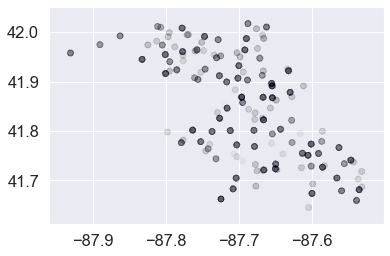

In [167]:
# look at dispersion of virus incidence geographically
plt.scatter(agg_train.Longitude, agg_train.Latitude, c = agg_train.WnvPresent, alpha = .01)

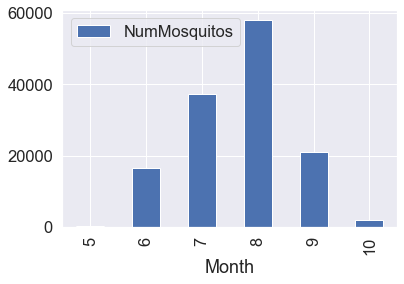

In [168]:
# look at incidence of cases over months
agg_train[['Month', 'NumMosquitos']].groupby("Month").sum().plot(kind='bar')

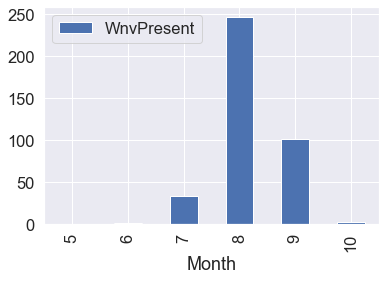

In [169]:
# look at incidence of cases over months
agg_train[['Month', 'WnvPresent']].groupby("Month").sum().plot(kind='bar')

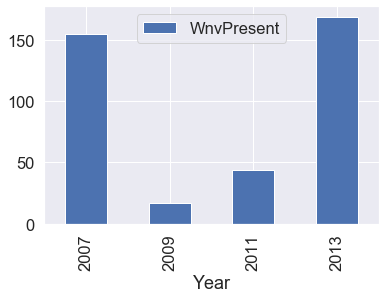

In [170]:
# look at incidence of cases over years
agg_train[['Year', 'WnvPresent']].groupby('Year').sum().plot(kind='bar')

## Baseline

In [237]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm, linear_model, datasets
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns



plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [261]:
X = combined_train.drop(["Latitude", "Longitude", "WnvPresent", "Trap", "Date", "YYMM", "Sunrise", "Sunset", "CodeSum", "Depth", "Water1", "SnowFall", "StnPressure", "SeaLevel"], axis=1)
y = combined_train.WnvPresent

In [262]:
X.columns

Index(['NumMosquitos', 'Year', 'Month', 'Station', 'Tmax', 'Tmin', 'Tavg',
       'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'PrecipTotal',
       'ResultSpeed', 'ResultDir', 'AvgSpeed', 'Daytime'],
      dtype='object')

In [263]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42)

In [264]:
class model_evaluation:
    
    def __init__(self, y_test, predicted_value):
        self.y_test = y_test
        self.predicted_value = predicted_value
        
    def confusion_matrix (self):
        tn, fp, fn, tp = confusion_matrix(self.y_test, self.predicted_value).ravel()
        print("True Negatives: %s" % tn)
        print("False Positives: %s" % fp)
        print("False Negatives: %s" % fn)
        print("True Positives: %s" % tp)
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        print("Precision: {}" .format (tp/(tp+fp)))
        print("Recall: {}" .format (tp/(tp+fn)))
        F1_score = 2*((precision*recall)/(precision+recall))
        print ("F1 score: {}" .format(2*((precision*recall)/(precision+recall))))
        self.score = F1_score

In [265]:
lr_model = LogisticRegression()

In [266]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
predicted_lr = lr.predict(X_test)
lrg = model_evaluation (y_test,predicted_lr)
lrg.confusion_matrix ()
lr.score (X_test, y_test)

True Negatives: 1053
False Positives: 3
False Negatives: 86
True Positives: 12
Precision: 0.8
Recall: 0.12244897959183673
F1 score: 0.21238938053097345


C:\Users\Yufung\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9228769497400346

### MODELS

In [198]:
#Test code, scaling of data, reduction of dimensionality, use of SVC.
from sklearn.decomposition import PCA
from sklearn.svm import SVC
pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('reduce_dims', PCA(n_components=4)),
    ('clf', SVC(kernel = 'linear', C = 1))])
param_grid = dict(reduce_dims__n_components=[4,6,8],
                  clf__C=np.logspace(-4, 1, 6),
                  clf__kernel=['rbf','linear'])


grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=param_grid, verbose=2, scoring='roc_auc')
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.cv_results_)
print(grid.score(X_test, y_test))


''' sample codes
#params={'model__C':[.01,.05,.1,.5,1,5,10],
           'model__penalty':['l1','l2']}
pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=40,ngram_range=(1,4))),
    ('tfidf', TfidfTransformer()),
    ('model',LogisticRegression())])
grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=params ,scoring='roc_auc')
grid.fit(train['text'], train['output'])
grid.score(test['text'], test['output'])


#pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', PCA(n_components=4)),
        ('clf', SVC(kernel = 'linear', C = 1))])

param_grid = dict(reduce_dims__n_components=[4,6,8],
                  clf__C=np.logspace(-4, 1, 6),
                  clf__kernel=['rbf','linear'])

grid = GridSearchCV(pipe, param_grid=param_grid, cv=3, n_jobs=1, verbose=2, scoring= 'accuracy')
grid.fit(X, y)
print(grid.best_score_)
print(grid.cv_results_)
'''

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    9.3s


0.8373136451664741
{'mean_fit_time': array([0.14938955, 0.14098315, 0.09720244, 0.06840076, 0.07679949,
       0.08459048, 0.11399879, 0.13140426, 0.12660503, 0.07197595,
       0.10318651, 0.09840088, 0.10499563, 0.122259  , 0.11310349,
       0.069837  , 0.12934861, 0.13189359, 0.12141719, 0.1284049 ,
       0.15419936, 0.07559953, 0.27465291, 0.23587747, 0.17591872,
       0.14872413, 0.12594633, 0.07800016, 0.96152029, 0.67134919,
       0.19898548, 0.18598971, 0.15180368, 0.23219686, 7.21116104,
       4.48841681]), 'std_fit_time': array([0.01602156, 0.03220082, 0.00617583, 0.01080711, 0.00449946,
       0.01029107, 0.02601279, 0.01191238, 0.00720236, 0.00328699,
       0.01117543, 0.00897497, 0.01153876, 0.00699715, 0.00796087,
       0.01359807, 0.01544233, 0.01633045, 0.00833827, 0.00441135,
       0.01032269, 0.00937222, 0.0048011 , 0.03915393, 0.01373966,
       0.00658572, 0.01834844, 0.00268369, 0.14060225, 0.0697054 ,
       0.02444241, 0.01169633, 0.00860274, 0.01489329, 

[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   19.0s finished


" sample codes\n#params={'model__C':[.01,.05,.1,.5,1,5,10],\n           'model__penalty':['l1','l2']}\npipeline = Pipeline([\n    ('vect', CountVectorizer(min_df=40,ngram_range=(1,4))),\n    ('tfidf', TfidfTransformer()),\n    ('model',LogisticRegression())])\ngrid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=params ,scoring='roc_auc')\ngrid.fit(train['text'], train['output'])\ngrid.score(test['text'], test['output'])\n\n\n#pipe = Pipeline([\n        ('scale', StandardScaler()),\n        ('reduce_dims', PCA(n_components=4)),\n        ('clf', SVC(kernel = 'linear', C = 1))])\n\nparam_grid = dict(reduce_dims__n_components=[4,6,8],\n                  clf__C=np.logspace(-4, 1, 6),\n                  clf__kernel=['rbf','linear'])\n\ngrid = GridSearchCV(pipe, param_grid=param_grid, cv=3, n_jobs=1, verbose=2, scoring= 'accuracy')\ngrid.fit(X, y)\nprint(grid.best_score_)\nprint(grid.cv_results_)\n"

In [ ]:
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('clf', SVC(kernel = 'linear', C = 1))])
param_grid = dict(clf__C=np.logspace(-4, 1, 6),
                  clf__kernel=['rbf','linear'])


grid = GridSearchCV(pipeline, cv=3, n_jobs=-1, param_grid=param_grid, verbose=2, scoring='roc_auc')
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.cv_results_)
grid.score(X_test, y_test)

In [ ]:
grid.best_params_

In [ ]:
#KNN
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('reduce_dims', PCA(n_components=4)),
    ('clf', KNeighborsClassifier())])
param_grid = dict(reduce_dims__n_components=[4,6,8],
                  clf__n_neighbors=range(1, 201, 10),
                  clf__metric=['euclidean', 'manhattan'])


grid = GridSearchCV(pipeline, cv=3, n_jobs=-1, param_grid=param_grid, verbose=2, scoring='roc_auc')
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.cv_results_)
grid.score(X_test, y_test)

In [ ]:
grid.best_params_

In [ ]:
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('clf', KNeighborsClassifier())])
param_grid = dict(clf__n_neighbors=range(1, 201, 10),
                  clf__metric=['euclidean', 'manhattan'])


grid = GridSearchCV(pipeline, cv=3, n_jobs=-1, param_grid=param_grid, verbose=2, scoring='roc_auc')
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.cv_results_)
grid.score(X_test, y_test)

In [ ]:
grid.best_params_

In [ ]:
#Multinomial is not applicable here due to the need for vectorizing, Decision trees will be used
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('reduce_dims', PCA(n_components=4)),
    ('clf', DecisionTreeClassifier())])
param_grid = dict(reduce_dims__n_components=[4,6,8],
                  clf__max_depth=[None,1,2,3,4,5],
                  clf__max_features=['sqrt', 'log2', None],
                  clf__min_samples_split=[2,3,4,5,10,15,20,25,30,40,50])


grid = GridSearchCV(pipeline, cv=3, n_jobs=-1, param_grid=param_grid, verbose=2, scoring='roc_auc')
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.cv_results_)
grid.score(X_test, y_test)


'''
n_params = {
    'max_depth': [None,1,2,3,4,5],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2,3,4,5,10,15,20,25,30,40,50]
    }

grid3 = GridSearchCV(DecisionTreeClassifier(), n_params, cv=5)
grid3.fit(X,y)
print ('best score = {}'.format(grid3.best_score_))
grid3.best_params_
'''


In [ ]:
grid.best_params_

In [ ]:
list_2 = zip(list(X.columns), list(grid.best_estimator_.steps[2][1].feature_importances_))
pl = pd.Series(dict(list_2)).sort_values(ascending=False)
pl

In [ ]:
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('clf', DecisionTreeClassifier())])
param_grid = dict(clf__max_depth=[None,1,2,3,4,5],
                  clf__max_features=['sqrt', 'log2', None],
                  clf__min_samples_split=[2,3,4,5,10,15,20,25,30,40,50])


grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=param_grid, verbose=2, scoring='roc_auc')
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.cv_results_)
print(grid.score(X_test, y_test))

In [ ]:
grid.best_params_

In [ ]:
#Example of feature importance: grid.best_estimator_.steps[1][1].feature_importances_
list_2 = zip(list(X.columns), list(grid.best_estimator_.steps[1][1].feature_importances_))
pl = pd.Series(dict(list_2)).sort_values(ascending=False)
pl.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [ ]:
#Random forest- of course we need a random search first yeah?
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(200, 2000, 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
'''
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
'''

# Use the random grid to search for best hyperparameters
# First create the base model to tune
#rc = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
#rc_random = RandomizedSearchCV(estimator = rc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model


pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('reduce_dims', PCA(n_components=4)),
    ('clf', RandomForestClassifier(random_state=42))])
param_grid = dict(reduce_dims__n_components=[4,6,8],
                  clf__n_estimators=[int(x) for x in np.linspace(200, 2000, 10)],
                  clf__max_features=['auto', 'sqrt'],
                  clf__max_depth=max_depth,
                  clf__min_samples_split=[2, 5, 10],
                  clf__min_samples_leaf=[1, 2, 4],
                  clf__bootstrap=[True, False]
                 )


rc_random = RandomizedSearchCV(pipeline, cv=3, n_jobs=-1, param_distributions=param_grid, n_iter = 100, verbose=2, scoring='roc_auc', random_state=42)
rc_random.fit(X_train, y_train)

In [ ]:
rc_random.best_params_

In [ ]:
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('reduce_dims', PCA(n_components=8)),
    ('clf', RandomForestClassifier(max_features='auto', bootstrap=True, min_samples_leaf=2,random_state=42))])

param_grid = dict(clf__n_estimators=[700, 800, 900],
                  clf__max_depth=[7,9,11,13],
                  clf__min_samples_split=[8,10,12,14],
                 )


grid = GridSearchCV(pipeline, cv=3, n_jobs=1, param_grid=param_grid, verbose=2, scoring='roc_auc')
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.cv_results_)
grid.score(X_test, y_test)

In [ ]:
grid.best_params_

In [ ]:
list_2 = zip(list(X.columns), list(grid.best_estimator_.steps[2][1].feature_importances_))
pl = pd.Series(dict(list_2)).sort_values(ascending=False)
pl.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(200, 2000, 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
'''
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
'''

# Use the random grid to search for best hyperparameters
# First create the base model to tune
#rc = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
#rc_random = RandomizedSearchCV(estimator = rc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model


pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))])
param_grid = dict(clf__n_estimators=[int(x) for x in np.linspace(200, 2000, 10)],
                  clf__max_features=['auto', 'sqrt'],
                  clf__max_depth=max_depth,
                  clf__min_samples_split=[2, 5, 10],
                  clf__min_samples_leaf=[1, 2, 4],
                  clf__bootstrap=[True, False]
                 )


rc_random = RandomizedSearchCV(pipeline, cv=3, n_jobs=-1, param_distributions=param_grid, n_iter = 100, verbose=2, scoring='roc_auc', random_state=42)
rc_random.fit(X_train, y_train)

In [ ]:
rc_random.best_params_

In [ ]:
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('clf', RandomForestClassifier(max_features='sqrt', bootstrap=True,random_state=42))])

param_grid = dict(clf__n_estimators=[1300, 1400, 1500],
                  clf__max_depth=[7,9,11,13],
                  clf__min_samples_split=[4,5,6],
                  clf__min_samples_leaf=[4,6,8]
                 )


grid = GridSearchCV(pipeline, cv=3, n_jobs=1, param_grid=param_grid, verbose=2, scoring='roc_auc')
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.cv_results_)
grid.score(X_test, y_test)

In [ ]:
grid.best_params_

In [ ]:
list_2 = zip(list(X.columns), list(grid.best_estimator_.steps[1][1].feature_importances_))
pl = pd.Series(dict(list_2)).sort_values(ascending=False)
pl.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('reduce_dims', PCA(n_components=4)),
    ('clf', AdaBoostClassifier(random_state=42))])
param_grid = dict(reduce_dims__n_components=[4,6,8],
                  clf__n_estimators=[150, 200],
                  clf__learning_rate=[0.01,0.05,0.1,0.3,1],
                 )


ad_random = RandomizedSearchCV(pipeline, cv=3, n_jobs=-1, param_distributions=param_grid, n_iter = 100, verbose=2, scoring='roc_auc', random_state=42)
ad_random.fit(X_train, y_train)


In [ ]:
ad_random.best_params_

In [ ]:
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('reduce_dims', PCA(n_components=6)),
    ('clf', AdaBoostClassifier(random_state=42))])

param_grid = dict(clf__n_estimators=[200,250],
                  clf__learning_rate=[0.1,0.2,0.25,0.3,0.35]
                 )


grid = GridSearchCV(pipeline, cv=3, n_jobs=1, param_grid=param_grid, verbose=2, scoring='roc_auc')
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.cv_results_)
grid.score(X_test, y_test)

In [ ]:
grid.best_params_

In [ ]:
list_2 = zip(list(X.columns), list(grid.best_estimator_.steps[2][1].feature_importances_))
pl = pd.Series(dict(list_2)).sort_values(ascending=False)
pl.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [ ]:
#Adaboost without PCA
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('clf', AdaBoostClassifier(random_state=42))])
param_grid = dict(clf__n_estimators=[150, 200],
                  clf__learning_rate=[0.01,0.05,0.1,0.3,1],
                 )


ad_random = RandomizedSearchCV(pipeline, cv=3, n_jobs=-1, param_distributions=param_grid, n_iter = 100, verbose=2, scoring='roc_auc', random_state=42)
ad_random.fit(X_train, y_train)

In [ ]:
ad_random.best_params_

In [ ]:
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('clf', AdaBoostClassifier(random_state=42))])

param_grid = dict(clf__n_estimators=[200,250],
                  clf__learning_rate=[0.1,0.2,0.25,0.3,0.35]
                 )


grid = GridSearchCV(pipeline, cv=3, n_jobs=1, param_grid=param_grid, verbose=2, scoring='roc_auc')
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.cv_results_)
grid.score(X_test, y_test)

In [ ]:
grid.best_params_

In [ ]:
list_2 = zip(list(X.columns), list(grid.best_estimator_.steps[1][1].feature_importances_))
pl = pd.Series(dict(list_2)).sort_values(ascending=False)
pl.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [ ]:
#Gradientboosting with PCA
from sklearn.ensemble import GradientBoostingClassifier
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('reduce_dims', PCA(n_components=4)),
    ('clf', GradientBoostingClassifier(random_state=42))])
param_grid = dict(reduce_dims__n_components=[4,6,8],
                  clf__min_samples_split=[50, 100],
                  clf__min_samples_leaf=[1,2,4],
                  clf__max_features=['auto','sqrt', 'log2'],
                  clf__max_depth = [5,6,7,8]
                 )

gb_random = RandomizedSearchCV(pipeline, cv=3, n_jobs=-1, param_distributions=param_grid, n_iter = 100, verbose=2, scoring='roc_auc', random_state=42)
gb_random.fit(X_train, y_train)

In [ ]:
gb_random.best_params_

In [ ]:
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('reduce_dims', PCA(n_components=8)),
    ('clf', GradientBoostingClassifier(min_samples_leaf=2, max_depth= 6,random_state=42))])

param_grid = dict(clf__min_samples_split=[100,150],
                  clf__max_features=['auto','sqrt', 'log2']
                 )


grid = GridSearchCV(pipeline, cv=3, n_jobs=1, param_grid=param_grid, verbose=2, scoring='roc_auc')
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.cv_results_)
grid.score(X_test, y_test)

In [ ]:
grid.best_params_

In [ ]:
list_2 = zip(list(X.columns), list(grid.best_estimator_.steps[2][1].feature_importances_))
pl = pd.Series(dict(list_2)).sort_values(ascending=False)
pl.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [ ]:
#gradientboosting without PCA
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('clf', GradientBoostingClassifier(random_state=42))])
param_grid = dict(clf__min_samples_split=[50, 100],
                  clf__min_samples_leaf=[1,2,4],
                  clf__max_features=['auto','sqrt', 'log2'],
                  clf__max_depth = [5,6,7,8]
                 )

gb_random = RandomizedSearchCV(pipeline, cv=3, n_jobs=-1, param_distributions=param_grid, n_iter = 100, verbose=2, scoring='roc_auc', random_state=42)
gb_random.fit(X_train, y_train)

In [ ]:
gb_random.best_params_

In [ ]:
pipeline = Pipeline([
    #('poly_feat', PolynomialFeatures(degree=3, interaction_only=True)),
    ('scale', StandardScaler()),
    ('clf', GradientBoostingClassifier(min_samples_leaf=1, max_features= 'sqrt',random_state=42))])

param_grid = dict(clf__min_samples_split=[30,40,50],
                  clf__max_depth=[3,4,5]
                 )


grid = GridSearchCV(pipeline, cv=3, n_jobs=1, param_grid=param_grid, verbose=2, scoring='roc_auc')
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.cv_results_)
grid.score(X_test, y_test)

In [ ]:
grid.best_params_

In [ ]:
list_2 = zip(list(X.columns), list(grid.best_estimator_.steps[1][1].feature_importances_))
pl = pd.Series(dict(list_2)).sort_values(ascending=False)
pl.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

Some takeaways, random forest seems to do the best. PCA did not really help much and could be due to small number of features. Adaboost learning rate seems to balance off with the estimators. higher estimators = lower learning rate. When doing decision trees, features that are the most important is heavily skewed to number of mosquitos. Baseline should be treated as 94% because this is supposed to be rare. Considering a binary classification problem, one can always assume the mosquito is not infected and still get it right 94% of the time.

Moving forward: Makes sense to predict the number of mosquitos first? then do a classification? Read other solutions. Find ways to process the features, date/time stuff and encoding of some of the categorical ones. Break the baseline.

Done: Pipelines Gridsearch Randomized search PCA